In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import random

In [11]:
class Bandit:
  def __init__(self, m):
    self.m = m
    self.mean = 0
    self.N = 0
    self.stdev = 0

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    
        
    if self.N > 2:
        self.stdev = math.sqrt((self.N-2)/(self.N-1) * self.stdev ** 2 + 1 / self.N * (x - self.mean) ** 2)
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x
    if self.N == 2:
        self.stdev = math.sqrt((2* self.mean - x)**2 + x ** 2 - 2 * self.mean**2)

In [40]:
def highestProbabilityChoose(bandits):  
    intersectionArray = np.ones((len(bandits),len(bandits)))
    for i in range(len(bandits)):
        for j in range(len(bandits)):
            if j == i:
                continue
            firstStandardDevMean = (bandits[i].stdev / math.log(bandits[i].N))
            secondStandardDevMean = (bandits[j].stdev / math.log(bandits[j].N))
            z = (bandits[i].mean - bandits[j].mean) / math.sqrt(firstStandardDevMean**2 + secondStandardDevMean**2)
            intersectionArray[i][j] = st.norm.cdf(z)
            
    unNormalizedProbabilities = []
    for i in range(intersectionArray.shape[0]):
        probHighest = 1
        for j in range(intersectionArray.shape[1]):
            probHighest = probHighest * intersectionArray[i][j]
        unNormalizedProbabilities.append(probHighest)
    
    total = sum(unNormalizedProbabilities)
    normalizedList = [x / total for x in unNormalizedProbabilities]
    cumulativeProbability = []
    runningTotal = 0
    for x in normalizedList:
        runningTotal += x
        cumulativeProbability.append(runningTotal)
    
    randomNumber = random.random()
    for i in range(len(cumulativeProbability)):
        if randomNumber <= cumulativeProbability[i]:
            return i

def runExperiment(numberOfBandits, eps, N):
    allBandits = []
    
    shiftPoint = int(N*random.uniform(0.2, .8))
    #print("Shift point is ", str(shiftPoint))
    
    bandits=[]
    for i in range(numberOfBandits):
        mean = (random.randint(1,10) + np.random.randn())
        bandits.append(Bandit(mean))
    allBandits.append(bandits)
    
    
    for i in range(2):
        temp = []
        for y in bandits:
            temp.append(Bandit(y.m))
        allBandits.append(temp)

    
    secondMeans = []
    for i in range(numberOfBandits):
        secondMeans.append((random.randint(1,10) + np.random.randn()))
    
    numberOfPulls = 0
    tempN = []
    dataProbabilityChoose = np.empty(N)
    expectedValue = 0
    for i in range(2):
        for bandit in allBandits[0]:
            x = bandit.pull()
            bandit.update(x)
            dataProbabilityChoose[numberOfPulls] = x
            numberOfPulls +=1
    for i in range(N-numberOfBandits*2):
        if numberOfPulls == shiftPoint:
            for i in range(numberOfBandits):
                expectedValue += allBandits[0][i].N*allBandits[0][i].m
                tempN.append(allBandits[0][i].N)
                #print(allBandits[0][i].mean, end = " ")
                allBandits[0][i].m = secondMeans[i]
            #print()
        indexToPull = highestProbabilityChoose(allBandits[0])
        x = allBandits[0][indexToPull].pull()
        allBandits[0][indexToPull].update(x)
        dataProbabilityChoose[numberOfPulls] = x
        numberOfPulls += 1
        
        
    cumulative_average = np.cumsum(dataProbabilityChoose) / (np.arange(N) + 1)

    
    count = 0
    for b in allBandits[0]:
        
        #print(b.mean, end = " ")
        expectedValue += (b.N-tempN[count])*b.m
        count += 1
    tempN = []
    #print()
    probabilityChooseResults = (cumulative_average, expectedValue)        
    
    expectedValue = 0
    epsilonGreedyData = np.empty(N)
    for i in range(N):
        if i == shiftPoint:
            for i in range(numberOfBandits):
                expectedValue += allBandits[1][i].N*allBandits[1][i].m
                tempN.append(allBandits[1][i].N)
                allBandits[1][i].m = secondMeans[i]
        p = np.random.random()
        if p < eps:
            j = np.random.choice(numberOfBandits)
        else:
            j = np.argmax([b.mean for b in allBandits[1]])
        x = allBandits[1][j].pull()
        allBandits[1][j].update(x)
        epsilonGreedyData[i] = x
    
    cumulative_average = np.cumsum(epsilonGreedyData) / (np.arange(N) + 1)
    count = 0
    
    for b in allBandits[1]:
        #print(b.mean, end = " ")
    
        expectedValue += (b.N-tempN[count])*b.m
        count += 1
    #print()
    epsilonGreedyResults = (cumulative_average, expectedValue)     


    decayEps = eps
            
    decayEpsData = np.empty(N)
    expectedValue = 0
    tempN = []
    
    for i in range(N):
        if i == shiftPoint:
            for i in range(numberOfBandits):
                tempN.append(allBandits[2][i].N)
                expectedValue += allBandits[2][i].N*allBandits[2][i].m
                allBandits[2][i].m = secondMeans[i]
        p = np.random.random()
        if p < decayEps:
            j = np.random.choice(numberOfBandits)
            decayEps = .99 * decayEps
        else:
            j = np.argmax([b.mean for b in allBandits[2]])
        x = allBandits[2][j].pull()
        allBandits[2][j].update(x)

        decayEpsData[i] = x
    cumulative_average = np.cumsum(decayEpsData) / (np.arange(N) + 1)

  # plot moving average ctr
    '''
    plt.plot(cumulative_average)
    plt.plot(np.ones(N)*m1)
    plt.plot(np.ones(N)*m2)
    plt.plot(np.ones(N)*m3)
    plt.xscale('log')
    plt.show()
    '''

    count = 0
    for b in allBandits[2]:
        expectedValue += (b.N-tempN[count])*b.m
        count += 1
                                                               
    #print()
    epsDecayResults = (cumulative_average, expectedValue)
    
    return [probabilityChooseResults, epsilonGreedyResults, epsDecayResults]

2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 

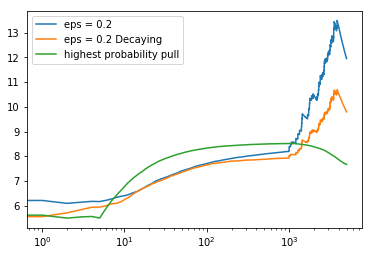

Expected Values
Probability Choosing:  38348
Epsilon Greedy:  36573
Epsilon Decay:  37602


In [43]:
if __name__ == '__main__':
    numberOfTrials = 100
    for x in range(numberOfTrials):
        if (x+1) % 2 == 0:
            print(x+1, end=" ")
            
        results = runExperiment(3,0.2,5000)
        if x == 0:
            probCumulativeAverage = results[0][0]
            probExpectedValue = results[0][1]
            epsGreedyCumulativeAverage = results[1][0]
            epsGreedyExpectedValue = results[1][1]
            epsDecayCumulativeAverage = results[2][0]
            epsDecayExpectedValue = results[2][1]
        else:
            probCumulativeAverage = [x + y for x, y in zip(probCumulativeAverage, results[0][0])]
          
            epsDecayCumulativeAverage = [x + y for x, y in zip(epsDecayCumulativeAverage, results[1][0])]
            epsGreedyCumulativeAverage = [x + y for x, y in zip(epsGreedyCumulativeAverage, results[2][0])]
            
            probExpectedValue += results[0][1]
            epsGreedyExpectedValue += results[1][1]
            epsDecayExpectedValue += results[2][1]       
    plt.plot([x / numberOfTrials for x in epsGreedyCumulativeAverage], label='eps = 0.2')
    plt.plot([x / numberOfTrials for x in epsDecayCumulativeAverage], label='eps = 0.2 Decaying')
    plt.plot([x / numberOfTrials for x in probCumulativeAverage], label="highest probability pull")
    plt.legend()
    plt.xscale('log')
    plt.show()
    
    print("Expected Values")
    print("Probability Choosing: ", int(probExpectedValue/numberOfTrials))
    print("Epsilon Greedy: ", int(epsGreedyExpectedValue/numberOfTrials))
    print("Epsilon Decay: ", int(epsDecayExpectedValue/numberOfTrials))